# CMPT 898: Assigment 2 Solutions
## By Samuel Horovatin, sch923, 11185403

### Question 1: *Re-implement the Keras tutorial for image classification in TensorFlow without using tf.keras objects.*

In [1]:
import tensorflow as tf
import numpy as np
import os, datetime

epochs = 50

(x_train, y_train),(x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalization of x_train and x_test
x_train, x_test = x_train / 255.0, x_test / 255.0


4423680/4422102 [==============================] - 0s 0us/step


In [202]:
#REMOVE BEFORE SUBMISSION

weight_1 = gen_random_vector(x_train[0].size)
weight_2 = gen_random_vector(x_train[0].size)
bias_1 = gen_random_vector(x_train[0].size)
bias_2 = gen_random_vector(x_train[0].size)

def gen_random_vector(size):
  return tf.Variable(
      tf.random_uniform_initializer(minval=0., maxval=1.)(shape=[1, size],
      dtype=tf.float64))

# Takes a tensor and by default flattens it to 1 by size of the input tensor
def flatten(tensor):
  return tf.Variable(tf.reshape(tensor, (1,tf.size(tensor))), shape=(1,tf.size(tensor)))

# A relu density function. Takes a tensor x, scalar wieght W, and tensor bias b.
def dense_relu(x, W, b):
  return tf.nn.relu(x*W + b)

# A dropout function that by default converts 20% of the input tensor x to 0.
def dropout(tensor,rate=0.2):
  return tf.nn.dropout(tensor, rate)

# A softmax density function. Takes a tensor x, scalar wieght W, and a tensor b.
def dense_softmax(x, W, b):
  return tf.nn.softmax(x*W + b)

def network_step(x, W1, W2, B1, B2):
  x = flatten(x)
  x = dense_relu(x, W1, B1)
  x = dropout(x)
  x = dense_softmax(x, W2, B2)
  return x

# A cross entropy loss function that takes in a vector of actual probabilities and a vector of predicted probabilities
def cross_entropy(actual_p, predicted_p):
  pre_sum_matrix = tf.math.multiply(actual_p, tf.math.log(predicted_p))
  return (-1 * tf.math.reduce_sum(pre_sum_matrix))

def gradiant_step_optimizer(weight, actual_p, predicted_p, alpha=0.1):
  print(f"Weight: {weight}")
  print(f"actual_p: {actual_p}")
  print(f"predicted_p: {tf.argmax(predicted_p, axis=1)}")
  with tf.GradientTape() as tape:
    y = cross_entropy(actual_p, predicted_p)
  grad = tape.gradient(y, [actual_p, predicted_p])[0]
  return tf.math.subtract(weights, grad*alpha)


x_estimate = network_step(x_train[0], weight_1, weight_2, bias_1, bias_2)
weight_1 = gradiant_step_optimizer(weight_1, y_train[0], x_estimate, alpha=0.001)
weight_2 = gradiant_step_optimizer(weight_2, y_train[0], x_estimate, alpha=0.001)
bias_1 = gradiant_step_optimizer(bias_1, y_train[0], x_estimate, alpha=0.001)
bias_2 = gradiant_step_optimizer(bias_2, y_train[0], x_estimate, alpha=0.001)
print(x_estimate)


Weight: <tf.Variable 'Variable:0' shape=(1, 784) dtype=float64, numpy=
array([[0.74504289, 0.00142531, 0.5142282 , 0.39260297, 0.23379291,
        0.70888182, 0.47991739, 0.23855623, 0.31911449, 0.98939456,
        0.72713879, 0.97267987, 0.50859441, 0.47627888, 0.57439478,
        0.42307144, 0.56765845, 0.89714288, 0.35970402, 0.08264183,
        0.8912803 , 0.23983863, 0.32222743, 0.28326454, 0.46061047,
        0.69430067, 0.92625993, 0.70367903, 0.06533488, 0.14510979,
        0.0895523 , 0.25811714, 0.04345961, 0.09323201, 0.02277669,
        0.32306604, 0.57606134, 0.84907249, 0.28097148, 0.58125012,
        0.35624902, 0.79355976, 0.02389287, 0.90762705, 0.72080788,
        0.01032565, 0.2464209 , 0.03628389, 0.38656674, 0.42583993,
        0.74329654, 0.10240198, 0.51646617, 0.898871  , 0.01917322,
        0.55784936, 0.35049964, 0.61185742, 0.35060308, 0.89028529,
        0.66184831, 0.98932435, 0.2777414 , 0.43522318, 0.51127187,
        0.89985599, 0.60931766, 0.46141476, 0

AttributeError: ignored

In [159]:
# Takes a tensor and by default flattens it to 1 by size of the input tensor
def flatten(tensor):
  return tf.reshape(tensor, tf.size(tensor))

# A relu density function. Takes a tensor x, scalar wieght W, and tensor bias b.
def dense_relu(x, W, b):
  return tf.nn.relu(tf.matmul(x, W) + b)

# A dropout function that by default converts 20% of the input tensor x to 0.
def dropout(tensor,rate=0.2):
  return tf.nn.dropout(tensor, rate)

# A softmax density function. Takes a tensor x, scalar wieght W, and a tensor b.
def dense_softmax(x, W, b):
  return tf.nn.softmax(tf.matmul(x, W) + b)

# A cross entropy loss function that takes in a vector of actual probabilities and a vector of predicted probabilities
def cross_entropy(actual_p, predicted_p):
  pre_sum_matrix = tf.math.multiply(actual_p, tf.math.log(predicted_p))
  return (-1 * tf.math.reduce_sum(pre_sum_matrix))

def gradiant_step_optimizer(weight, actual_p, predicted_p, alpha=0.1):
  with tf.GradientTape() as tape:
    y = cross_enthropy(actual_p, predicted_p)
  grad = tape.gradient(y, [actual_p, predicted_p])[0]
  return tf.math.subtract(weights, grad*alpha)

def gen_random_vector(size):
  return tf.Variable(
      tf.random_uniform_initializer(minval=0., maxval=1.)(shape=[1, size],
      dtype=tf.float32))

@tf.function
def network_step(x, W1, W2, B1, B2):
  x = flatten(x)
  x = dense_relu(x, W1, B1)
  x = dropout(x)
  x = dense_softmax(x, W2, B2)
  return x


def train_model(epochs, x_train, y_train):
  weight_1 = gen_random_vector(x_train.size)
  weight_2 = gen_random_vector(x_train.size)
  bias_1 = gen_random_vector(x_train.size)
  bias_2 = gen_random_vector(x_train.size)

  for i in range(epochs):
    for x_tens, y_tens in zip(x_train, y_train):
      x_estimate = network_step(x_tens, weight_1, weight_2, bias_1, bias_2)
      weight_1 = gradiant_step_optimizer(weight_1, y_tens, x_estimate, alpha=0.001)
      weight_2 = gradiant_step_optimizer(weight_2, y_tens, x_estimate, alpha=0.001)
      bias_1 = gradiant_step_optimizer(bias_1, y_tens, x_estimate, alpha=0.001)
      bias_2 = gradiant_step_optimizer(bias_2, y_tens, x_estimate, alpha=0.001)
  
  return weight_1, weight_2, bias_1, bias_2


def evaluate_model(x_test, y_test, weight_1, weight_2, bias_1, bias_2):
  # Define our metrics
  test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
  test_accuracy = tf.keras.metrics.CategoricalAccuracy('test_accuracy')

  for x_tens, y_tens in zip(x_test, y_test):
    x_estimate = network_step(x_tens, weight_1, weight_2, bias_1, bias_2)

    loss = cross_entropy(y_test, x_estimate)
    test_loss(loss)
    test_accuracy(y_test, x_estimate)

    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

weight_1, weight_2, bias_1, bias_2 = train_model(epochs, x_train, y_train)
evaluate_model(x_test, y_test, weight_1, weight_2, bias_1, bias_2)
%tensorboard --logdir logs/gradient_tape


ValueError: ignored

### Question 2: Create two random square matrix and preform matrix multiplication. Create a table to report the compute time for CPU vs GPU for matrix size 500, 1000, 5000, 10000.

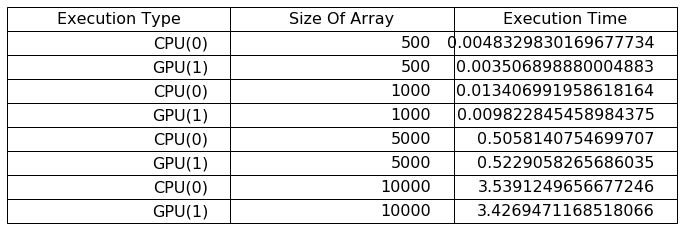

In [ ]:
import tensorflow as tf
import time
import pandas as pd
import matplotlib.pyplot as plt

# Generates a random square matrix of size x 
def gen_square_matrix(x):
  return tf.Variable( tf.random.normal(shape=[x,x],seed=43) )

# Generates two random square matrix of size x 
# and reports the time in seconds it takes to matrix multiply them.
def time_matrix_multiplication(x):
    start_time = time.time()
    tf.matmul(gen_square_matrix(x), gen_square_matrix(x))
    elapse_time = time.time()-start_time
    return elapse_time

# Preform CPU Multiplication
with tf.device('/cpu:0'):
  CPU_time_500 = time_matrix_multiplication(500)
  CPU_time_1000 = time_matrix_multiplication(1000)
  CPU_time_5000 = time_matrix_multiplication(5000)
  CPU_time_10000 = time_matrix_multiplication(10000)

# Preform GPU Multiplication
with tf.device('/device:GPU:0'):
  GPU_time_500 = time_matrix_multiplication(500)
  GPU_time_1000 = time_matrix_multiplication(1000)
  GPU_time_5000 = time_matrix_multiplication(5000)
  GPU_time_10000 = time_matrix_multiplication(10000)

# Create table
fig, axes = plt.subplots()

# Hides unneeded axes
fig.patch.set_visible(False)
axes.axis('off')
axes.axis('tight')

# Data assembly
tablelabel = ("Execution Type", "Size Of Array", "Execution Time")
tabledata = ([("CPU(0)", 500, CPU_time_500),
              ("GPU(1)", 500, GPU_time_500),
              ("CPU(0)", 1000, CPU_time_1000), 
              ("GPU(1)", 1000, GPU_time_1000),
              ("CPU(0)", 5000, CPU_time_5000), 
              ("GPU(1)", 5000, GPU_time_5000),
              ("CPU(0)", 10000, CPU_time_10000),
              ("GPU(1)", 10000, GPU_time_10000)])
table_df = pd.DataFrame(tabledata, columns=tablelabel)
 
# Plot table with some formatting
table = axes.table(cellText=table_df.values, colLabels=table_df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(16)
table.scale(2,2)
plt.show()

### Question 3: Given the polynomial $y = x^2 + 2x +3$, implement the expression in tensor flow, and print out the result of performing differentiation of the expression. Compare this to the result of evaluating a manually derived expression by hand. Use the test case $x = \begin{pmatrix} 2\\ 4\end{pmatrix}$.

In [ ]:
import tensorflow as tf

#A function that takes a vector x and returns the result of gradiant of x^2 + 2x +3 with the inputted x
def poly_derivative(x):
    if not isinstance(x, tf.Variable):
        x = tf.Variable(x)
    with tf.GradientTape() as tape:
        y = tf.math.multiply(x, x) + 2*x + 3
    return tape.gradient(y, [x])

#First test using the example vector x_1 = (2, 4)^T
for element in poly_derivative([2.,4.]):
    print(element)

#Second test using a larger vector x_2 = (0.5, 10, 4, 8)^T
for element in poly_derivative([0.5, 10., 4., 8.]):
    print(element)

tf.Tensor([ 6. 10.], shape=(2,), dtype=float32)
tf.Tensor([ 3. 22. 10. 18.], shape=(4,), dtype=float32)
